<a href="https://colab.research.google.com/github/Lawi365/ML-01/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
`Classification Walkthrough Titanic Dataset.`
```

# IMPORTS

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    ensemble,
    preprocessing,
    tree
)

from sklearn.metrics import (
    auc,confusion_matrix,roc_auc_score,roc_curve
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from yellowbrick.classifier import(
    ConfusionMatrix,ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve,
)
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install --upgrade xlrd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
df = pd.read_excel("/content/titanic3.xls")
orig_df = df

In [7]:
orig_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [8]:
print(orig_df.shape)

(1309, 14)




### DATA EXPLORATION AND VISUALIZATION



In [9]:
orig_df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [10]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [11]:
#we need to drop some values
# boat and body will leak some of the information.
df_droped = df.drop(columns=["boat","body","name",'ticket'])
#added name cos Doesnt seem relevant.
df_droped.columns
df_droped.shape

(1309, 10)

In [12]:
#get dummies for the categorical class
df_droped.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'home.dest'],
      dtype='object')

In [13]:
df_dummies = pd.get_dummies(df_droped,columns=['cabin',
                            'sex','embarked','home.dest'],drop_first=True)

In [14]:
df_dummies.head(3)

,pclass,survived,age,sibsp,parch,fare,cabin_A11,cabin_A14,cabin_A16,cabin_A18,...,"home.dest_Wimbledon Park, London / Hayling Island, Hants","home.dest_Windsor, England New York, NY","home.dest_Winnipeg, MB","home.dest_Winnipeg, MN","home.dest_Woodford County, KY","home.dest_Worcester, England","home.dest_Worcester, MA","home.dest_Yoevil, England / Cottage Grove, OR","home.dest_Youngstown, OH","home.dest_Zurich, Switzerland"
0,1,1,29.0000,0,0,211.3375,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.9167,1,2,151.5500,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,2.0000,1,2,151.5500,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_dummies.isnull().sum()
#only age contains missing values.
#need a strategy to overcome that.



pclass                                             0
survived                                           0
age                                              263
sibsp                                              0
parch                                              0
                                                ... 
home.dest_Worcester, England                       0
home.dest_Worcester, MA                            0
home.dest_Yoevil, England / Cottage Grove, OR      0
home.dest_Youngstown, OH                           0
home.dest_Zurich, Switzerland                      0
Length: 562, dtype: int64

In [16]:
# create a X,y 
X = df_dummies.drop(columns='survived')
y = df_dummies.survived

print(X.columns,y.shape)


Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin_A11', 'cabin_A14',
       'cabin_A16', 'cabin_A18', 'cabin_A19',
       ...
       'home.dest_Wimbledon Park, London / Hayling Island, Hants',
       'home.dest_Windsor, England New York, NY', 'home.dest_Winnipeg, MB',
       'home.dest_Winnipeg, MN', 'home.dest_Woodford County, KY',
       'home.dest_Worcester, England', 'home.dest_Worcester, MA',
       'home.dest_Yoevil, England / Cottage Grove, OR',
       'home.dest_Youngstown, OH', 'home.dest_Zurich, Switzerland'],
      dtype='object', length=561) (1309,)


In [17]:
#HERE'S A STRATEGY I'VE SEEN
#FIRST IMPUTE ON THE TRAINING

X_train,X_test,y_train,y_test = train_test_split(
    X,y, test_size =0.3, random_state=42
)

(array([ 49.,  49., 199., 182., 103.,  76.,  42.,  24.,   3.,   2.]),
 array([ 0.1667 ,  8.15003, 16.13336, 24.11669, 32.10002, 40.08335,
        48.06668, 56.05001, 64.03334, 72.01667, 80.     ]),
 <a list of 10 Patch objects>)

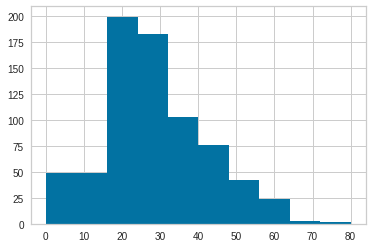

In [18]:
#YOU CAN USE PANDAS FILLNA. TO FILL THE MEDIANS.
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(X_train['age'])


In [19]:
#Because the plot seem normal we will fill them using mean.
mean = X_train.mean()
mean2 = X_test.mean()

In [20]:
X_train = X_train.fillna(mean)
X_test = X_test.fillna(mean2)


## classifiers

In [21]:
from sklearn.dummy import DummyClassifier

bm = DummyClassifier()
bm.fit(X_train,y_train)
bm.score(X_test,y_test)


0.5699745547073791

In [22]:
#VARIOUS CLASSIFICATION FAMILIES.
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier
)
import xgboost

In [23]:
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])
from sklearn import model_selection
for model in [DummyClassifier,LogisticRegression,DecisionTreeClassifier,
              KNeighborsClassifier,GaussianNB,SVC,RandomForestClassifier,
              xgboost.XGBClassifier]:
    cls = model()
    kfold = model_selection.KFold(n_splits= 10, random_state=42,shuffle=True)
    s = model_selection.cross_val_score(cls,X,y,scoring='roc_auc',cv=kfold)
    print(
        f"{model.__name__:22} AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}"
    )


DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.843 STD: 0.03
DecisionTreeClassifier AUC: 0.784 STD: 0.03
KNeighborsClassifier   AUC: 0.717 STD: 0.04
GaussianNB             AUC: 0.717 STD: 0.05
SVC                    AUC: 0.733 STD: 0.06
RandomForestClassifier AUC: 0.859 STD: 0.03
XGBClassifier          AUC: 0.864 STD: 0.03


#### CREATE MODEL

In [24]:
rf = ensemble.RandomForestClassifier(
    n_estimators= 1000, random_state=42
)
rf.fit(X_train,y_train)



RandomForestClassifier(n_estimators=1000, random_state=42)

In [30]:
# EVALUATE MODEL
rf.score(X_test,y_test)

0.7888040712468194

In [27]:
# OPTIMIZE THE MODEL

fr4 = ensemble.RandomForestClassifier()
params = {
    'max_features': [0.7,'auto'],
    'n_estimators': [15,500],
    'min_samples_leaf': [1.6,0.1],
    'random_state': [42,98]
}

cv = model_selection.GridSearchCV(
    fr4, params, n_jobs=-1
).fit(X_train,y_train)

print(cv.best_params_)

{'max_features': 0.7, 'min_samples_leaf': 0.1, 'n_estimators': 15, 'random_state': 42}


In [33]:
rf5_best = ensemble.RandomForestClassifier(
    **{
        'max_features':0.7,
       'min_samples_leaf': 0.1,
       'n_estimators': 15,
       'random_state': 42
    }
).fit(X_train,y_train)
rf5_best.score(X_test,y_test)

0.7582697201017812

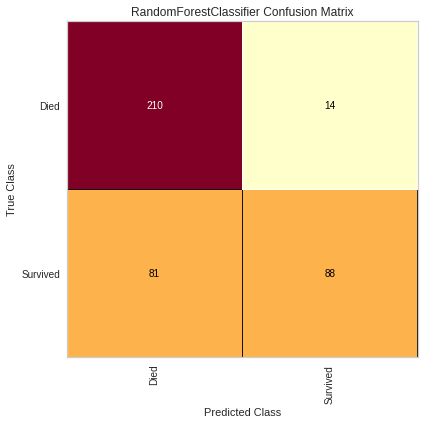

In [41]:
#CONFUSION MATRIX

from sklearn.metrics import confusion_matrix
y_pred = rf5_best.predict(X_test)

confusion_matrix(y_test,y_pred)

fig,ax = plt.subplots(figsize=(6,6))

cm_viz = ConfusionMatrix(
   rf5_best,
    classes=['Died','Survived'],
    label_encoder={0:'Died',1:'Survived'}
)
cm_viz.score(X_test,y_test)
cm_viz.poof()

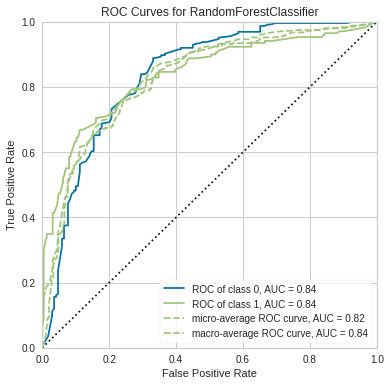

In [45]:
#ROC CURVE
fig,ax = plt.subplots(figsize=(6,6))
roc_viz = ROCAUC(rf5_best)
roc_viz.fit(X_train,y_train)
roc_viz.score(X_test,y_test)
roc_viz.poof()


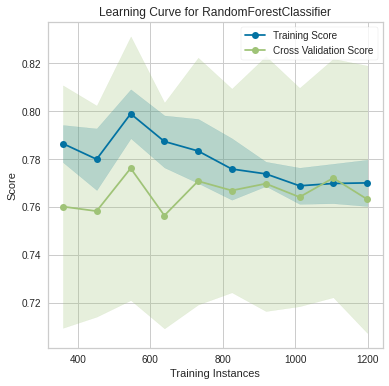

In [49]:
# LEARNING CURVE.
import numpy as np
sizes= np.linspace(0.3,1.0,10)
fig,ax = plt.subplots(figsize=(6,6))
cv = StratifiedKFold(12)
lc_viz = LearningCurve(
    rf5_best,
    cv=cv,
    train_sizes= sizes,
    scoring='f1_weighted',
    n_jobs=4,
    ax=ax
)
lc_viz.fit(X,y)
lc_viz.poof()


In [51]:
#Now that we have a working model
#DEPLOY THE MODEL
import pickle
pic = pickle.dumps(rf5_best)
rf6 = pickle.loads(pic)
y_pred = rf6.predict(X_test)
roc_auc_score(y_test,y_pred)

0.7291050295857988